In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import glob
import datetime
from pyproj import Proj, Transformer
import os
from scipy import interpolate

In [2]:
def to_binary_string(num):
    if np.isnan(num):
        return np.nan
    else:
        return f'{int(num):b}'

In [3]:
to_binary_string(55052)

'1101011100001100'

In [4]:
"""
Export coordinates for each urban area
KEY: [utm zone, T/F Northern Hemisphere]
"""
proj_zone = {
    'DMV':[18, True], 'NYC':[18, True], 'Phoenix':[12, True], 'Miami':[17, True], 'Chicago':[16, True], 'Denver':[13, True],
    'Seattle':[10, True], 'San_Francisco':[10, True], 'Los_Angeles':[11, True], 'Atlanta':[16, True], 'Toronto':[17, True],
    'Mexico_City':[14, True], 'Las_Vegas':[11, True], 'Salt_Lake_City':[12, True], 'Dallas':[14, True], 'Houston':[15, True],
    'New_Orleans':[15, True], 'St_Louis':[15, True], 'Minneapolis':[15, True], 'Jacksonville':[17, True], 'Charlotte':[17, True],
    'Philadelphia':[18, True], 'San_Diego':[11, True], 'San_Juan':[19, True], 'Montreal':[18, True], 'Guadalajara':[13, True],
    'Monterrey':[14, True], 'Cancun':[16, True], 'Billings':[12, True], 'Guatemala_City':[15, True], 'San_Jose':[16, True],
    'Havana':[17, True], 'Santo_Domingo':[19, True], 'Tegucigalpa':[16, True], 'Managua':[16, True], 'Panama_City':[17, True],
    'Bogota':[18, True], 'Lima':[18, False], 'Quito':[17, True], 'Santiago':[19, False], 'Buenos_Aires':[21, False],
    'Sao_Paulo':[23, False], 'Manaus':[20, False], 'Punta_Arenas':[19, False],
    'La_Paz':[19, False], 'Montevideo':[21, False], 'Brasilia':[22, False], 'Caracas':[19, True]
}

In [5]:
city = 'DMV'
city_zone = proj_zone[city]
city_zone

[18, True]

In [6]:
# Define UTM18N projection (WGS84 datum)
global utm_proj 
utm_proj = Proj(proj="utm", zone=city_zone[0], datum="WGS84", northern=city_zone[1])

# Sample Code

## Landsat

In [7]:
#times_Landsat = pd.read_csv('/Users/jonstar/Documents/heat_data/Landsat_times/Landsat_times_DMV.csv').value
times_Landsat = pd.read_csv(f'/home/jonstar/urban_heat_dataset/Landsat_times/Landsat_times_{city}.csv').value
times_Landsat

0     1.641657e+12
1     1.643039e+12
2     1.644422e+12
3     1.645804e+12
4     1.647186e+12
5     1.648569e+12
6     1.649951e+12
7     1.651334e+12
8     1.652716e+12
9     1.654098e+12
10    1.655481e+12
11    1.656863e+12
12    1.658246e+12
13    1.659628e+12
14    1.661010e+12
15    1.662393e+12
16    1.663775e+12
17    1.665158e+12
18    1.666540e+12
19    1.667922e+12
20    1.669305e+12
21    1.670687e+12
22    1.672070e+12
23    1.673452e+12
24    1.677599e+12
25    1.678982e+12
26    1.680364e+12
27    1.681746e+12
28    1.683129e+12
29    1.684511e+12
30    1.685894e+12
31    1.687276e+12
32    1.688658e+12
33    1.690041e+12
34    1.691423e+12
35    1.692806e+12
36    1.694188e+12
37    1.696953e+12
38    1.698335e+12
39    1.699718e+12
40    1.701100e+12
41    1.702482e+12
42    1.703865e+12
Name: value, dtype: float64

In [8]:
#Landsat_root = '/home/jonstar/scratch.gcurbanheat/temporary_Landsat_data'
Landsat_root = f'/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/{city}/Landsat'
Landsat_tif_list = glob.glob(Landsat_root+'/*.tif')
Landsat_tif_list

['/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202308071546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202210231547.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202305191545.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202306041545.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202311271546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202309081546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202207191546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202206011546.tif',


In [9]:
def sort_func_Landsat(s, form=int):
    if form == int:
        return int(s.split(f'{city}_')[1].split('.tif')[0])
    else:
        return str(s.split(f'{city}_')[1].split('.tif')[0])

In [10]:
Landsat_tif_list = sorted(Landsat_tif_list, key=sort_func_Landsat)
Landsat_tif_list

['/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202201081546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202201241546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202202091546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202202251546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202203131546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202203291546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202204141546.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202204301546.tif',


In [12]:
#dsLS = rxr.open_rasterio('/Users/jonstar/Documents/heat_data/Landsat_Sentinel_DMV_newest/Landsat_Sentinel_image_DMV_202201081546.tif')#[:,:3000,:3000]
dsLS = rxr.open_rasterio(Landsat_tif_list[0])[:,:3000,:3000]
geotiff_dsLS = dsLS.to_dataset('band')

In [13]:
geotiff_dsLS

<xarray.Dataset> Size: 936MB
Dimensions:      (y: 3000, x: 3000)
Coordinates:
  * x            (x) float64 24kB 5.464e+05 5.465e+05 ... 6.364e+05 6.364e+05
  * y            (y) float64 24kB 5.617e+05 5.617e+05 ... 4.718e+05 4.718e+05
    spatial_ref  int64 8B 0
Data variables: (12/13)
    1            (y, x) float64 72MB ...
    2            (y, x) float64 72MB ...
    3            (y, x) float64 72MB ...
    4            (y, x) float64 72MB ...
    5            (y, x) float64 72MB ...
    6            (y, x) float64 72MB ...
    ...           ...
    8            (y, x) float64 72MB ...
    9            (y, x) float64 72MB ...
    10           (y, x) float64 72MB ...
    11           (y, x) float64 72MB ...
    12           (y, x) float64 72MB ...
    13           (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'S...

In [13]:
y, x = np.meshgrid(geotiff_dsLS['y'], geotiff_dsLS['x'])
utm_coords = np.stack((x,y)).T.reshape(-1,2)
utm_coords

array([[ 703125., 3787635.],
       [ 703155., 3787635.],
       [ 703185., 3787635.],
       ...,
       [ 793035., 3697665.],
       [ 793065., 3697665.],
       [ 793095., 3697665.]], shape=(9000000, 2))

In [11]:
def stacked_to_latlon(pt):
    return utm_proj(pt[0], pt[1], inverse=True)

In [10]:
latlon_pts = np.array(list(map(stacked_to_latlon, utm_coords)))


KeyboardInterrupt


KeyboardInterrupt



In [16]:
latlon_pts = latlon_pts.reshape((3000,3000,2))
latlon_pts

array([[[-84.7951974 ,  34.20996642],
        [-84.79487198,  34.20996057],
        [-84.79454656,  34.20995472],
        ...,
        [-83.82039611,  34.1885584 ],
        [-83.82007104,  34.18854997],
        [-83.81974596,  34.18854154]],

       [[-84.79520445,  34.20969607],
        [-84.79487903,  34.20969021],
        [-84.79455361,  34.20968436],
        ...,
        [-83.82040626,  34.18828826],
        [-83.82008118,  34.18827983],
        [-83.81975611,  34.1882714 ]],

       [[-84.79521149,  34.20942571],
        [-84.79488607,  34.20941986],
        [-84.79456065,  34.209414  ],
        ...,
        [-83.82041641,  34.18801812],
        [-83.82009133,  34.18800969],
        [-83.81976626,  34.18800125]],

       ...,

       [[-84.81589204,  33.39964619],
        [-84.81556967,  33.39964052],
        [-84.8152473 ,  33.39963484],
        ...,
        [-83.85020904,  33.3788794 ],
        [-83.84988699,  33.37887122],
        [-83.84956495,  33.37886304]],

       [[-84.81

In [42]:
latlons_dir = '/home/jonstar/urban_heat_dataset/latlons'
xr.DataArray(latlon_pts, dims=['longitude','latitude','latlon_pts']).to_netcdf(f'{latlons_dir}/{city}_latlons.nc')

In [43]:
xr.open_dataarray(f'{latlons_dir}/{city}_latlons.nc').values

array([[[-84.7951974 ,  34.20996642],
        [-84.79487198,  34.20996057],
        [-84.79454656,  34.20995472],
        ...,
        [-83.82039611,  34.1885584 ],
        [-83.82007104,  34.18854997],
        [-83.81974596,  34.18854154]],

       [[-84.79520445,  34.20969607],
        [-84.79487903,  34.20969021],
        [-84.79455361,  34.20968436],
        ...,
        [-83.82040626,  34.18828826],
        [-83.82008118,  34.18827983],
        [-83.81975611,  34.1882714 ]],

       [[-84.79521149,  34.20942571],
        [-84.79488607,  34.20941986],
        [-84.79456065,  34.209414  ],
        ...,
        [-83.82041641,  34.18801812],
        [-83.82009133,  34.18800969],
        [-83.81976626,  34.18800125]],

       ...,

       [[-84.81589204,  33.39964619],
        [-84.81556967,  33.39964052],
        [-84.8152473 ,  33.39963484],
        ...,
        [-83.85020904,  33.3788794 ],
        [-83.84988699,  33.37887122],
        [-83.84956495,  33.37886304]],

       [[-84.81

In [17]:
# For Landsat/Sentinel tifs
geotiff_dsLS = geotiff_dsLS.rename({1:'Landsat_blue_reflectance', 2:'Landsat_green_reflectance', 3:'Landsat_red_reflectance',
                                    4:'Landsat_NIR_reflectance', 5:'Landsat_SWIR1_reflectance', 6:'Landsat_SWIR2_reflectance',
                                    7:'Landsat_LST', 8:'Landsat_cloud_mask', 9:'Sentinel1_VV', 10:'Sentinel1_VH', 11:'Sentinel1_HH',
                                    12:'Sentinel1_HV', 13:'Sentinel1_angle'})

In [18]:
geotiff_dsLS['Landsat_cloud_mask'].values

array([[21824., 21824., 21824., ..., 21824., 21824., 21824.],
       [21824., 21824., 21824., ..., 21824., 21824., 21824.],
       [21824., 21824., 21824., ..., 21824., 21824., 21824.],
       ...,
       [21824., 21824., 21824., ..., 21824., 21824., 21952.],
       [21824., 21824., 21824., ..., 21824., 21824., 21952.],
       [21824., 21824., 21824., ..., 21824., 21824., 21952.]],
      shape=(3000, 3000))

In [19]:
binary_vectorized = np.vectorize(to_binary_string)
mask = binary_vectorized(geotiff_dsLS.Landsat_cloud_mask.values)

In [20]:
mask

array([['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010101000000'],
       ['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010101000000'],
       ['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010101000000'],
       ...,
       ['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010111000000'],
       ['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010111000000'],
       ['101010101000000', '101010101000000', '101010101000000', ...,
        '101010101000000', '101010101000000', '101010111000000']],
      shape=(3000, 3000), dtype='<U16')

In [21]:
geotiff_dsLS['Landsat_cloud_mask'] = (('y', 'x'), mask)

In [22]:
geotiff_dsLS['Landsat_cloud_mask'].attrs['bitmask_key'] = \
"Bit 0: Fill\n\
Bit 1: Dilated Cloud\n\
Bit 2: Cirrus (high confidence)\n\
Bit 3: Cloud\n\
Bit 4: Cloud Shadow\n\
Bit 5: Snow\n\
Bit 6: Clear\n\t0: Cloud or Dilated Cloud bits are set\n\t1: Cloud and Dilated Cloud bits are not set\n\
Bit 7: Water\n\
Bits 8-9: Cloud Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 10-11: Cloud Shadow Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 12-13: Snow/Ice Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 14-15: Cirrus Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High"

In [23]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                     (y: 3000, x: 3000)
Coordinates:
  * x                           (x) float64 24kB 7.031e+05 ... 7.931e+05
  * y                           (y) float64 24kB 3.788e+06 ... 3.698e+06
    spatial_ref                 int64 8B 0
Data variables: (12/13)
    Landsast_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance   (y, x) float64 72MB ...
    Landsat_red_reflectance     (y, x) float64 72MB ...
    Landsat_NIR_reflectance     (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance   (y, x) float64 72MB ...
    Landsast_SWIR2_reflectance  (y, x) float64 72MB ...
    ...                          ...
    Landsat_cloud_mask          (y, x) <U16 576MB '101010101000000' ... '1010...
    Sentinel1_VV                (y, x) float64 72MB ...
    Sentinel1_VH                (y, x) float64 72MB ...
    Sentinel1_HH                (y, x) float64 72MB ...
    Sentinel1_HV                (y, x) float64 72MB ...
    Sentinel1_angle             (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'S...

In [24]:
dt = datetime.datetime.fromtimestamp(times_Landsat[0]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
geotiff_dsLS = geotiff_dsLS.assign_coords({'datetime':dt})

In [25]:
del geotiff_dsLS.attrs['long_name']

In [26]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                     (y: 3000, x: 3000)
Coordinates:
  * x                           (x) float64 24kB 7.031e+05 ... 7.931e+05
  * y                           (y) float64 24kB 3.788e+06 ... 3.698e+06
    spatial_ref                 int64 8B 0
    datetime                    <U20 80B '2022-01-04T16:12:36Z'
Data variables: (12/13)
    Landsast_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance   (y, x) float64 72MB ...
    Landsat_red_reflectance     (y, x) float64 72MB ...
    Landsat_NIR_reflectance     (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance   (y, x) float64 72MB ...
    Landsast_SWIR2_reflectance  (y, x) float64 72MB ...
    ...                          ...
    Landsat_cloud_mask          (y, x) <U16 576MB '101010101000000' ... '1010...
    Sentinel1_VV                (y, x) float64 72MB ...
    Sentinel1_VH                (y, x) float64 72MB ...
    Sentinel1_HH                (y, x) float64 72MB ...
    Sentinel1_HV                (y, x) float64 72MB ...
    Sentinel1_angle             (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [52]:
#geotiff_dsLS.to_netcdf('../../heat_data/Landsat_Sentinel_DMV_processed/processed_Landsat_0.nc')
geotiff_dsLS.to_netcdf('/home/jonstar/scratch.gcurbanheat/processed_Landsat_data/processed_Landsat_0.nc')

In [27]:
xr.open_dataset('/home/jonstar/scratch.gcurbanheat/processed_Landsat_data/processed_Landsat_0.nc')

<xarray.Dataset> Size: 936MB
Dimensions:                     (y: 3000, x: 3000)
Coordinates:
  * x                           (x) float64 24kB 7.031e+05 ... 7.931e+05
  * y                           (y) float64 24kB 3.788e+06 ... 3.698e+06
    datetime                    object 8B ...
Data variables: (12/14)
    Landsat_cloud_mask          (y, x) object 72MB ...
    Landsast_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance   (y, x) float64 72MB ...
    Landsat_red_reflectance     (y, x) float64 72MB ...
    Landsat_NIR_reflectance     (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance   (y, x) float64 72MB ...
    ...                          ...
    Sentinel1_VV                (y, x) float64 72MB ...
    Sentinel1_VH                (y, x) float64 72MB ...
    Sentinel1_HH                (y, x) float64 72MB ...
    Sentinel1_HV                (y, x) float64 72MB ...
    Sentinel1_angle             (y, x) float64 72MB ...
    spatial_ref                 int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## GOES

In [12]:
#times_GOES = pd.read_csv('/Users/jonstar/Documents/heat_data/GOES_East_times.csv').value
times_GOES = pd.read_csv('/home/jonstar/urban_heat_dataset/GOES_East_times.csv').value
times_GOES

0         1.640995e+12
1         1.640996e+12
2         1.640996e+12
3         1.640997e+12
4         1.640998e+12
              ...     
104725    1.704064e+12
104726    1.704065e+12
104727    1.704065e+12
104728    1.704066e+12
104729    1.704067e+12
Name: value, Length: 104730, dtype: float64

In [13]:
#GOES_tif_list = glob.glob('../../heat_data/GOES_DMV/*.tif')
GOES_tif_list = glob.glob('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/*.tif')
GOES_tif_list

['/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010000.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010010.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010020.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010030.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010040.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010050.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010100.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010110.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_20

In [14]:
def sort_func_GOES(s):
    return int(s.split('image_')[1].split('.tif')[0])

In [15]:
GOES_tif_list = sorted(GOES_tif_list, key=sort_func_GOES)
GOES_tif_list

['/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010000.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010010.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010020.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010030.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010040.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010050.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010100.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_202201010110.tif',
 '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_1/GOES_image_20

In [148]:
dsLS = rxr.open_rasterio('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/Landsat/Landsat_Sentinel_image_DMV_202207191546.tif')[:,:3000,:3000]
dsLS

<xarray.DataArray (band: 13, y: 3000, x: 3000)> Size: 936MB
[117000000 values with dtype=float64]
Coordinates:
  * band         (band) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * x            (x) float64 24kB 2.92e+05 2.92e+05 ... 3.819e+05 3.82e+05
  * y            (y) float64 24kB 4.372e+06 4.372e+06 ... 4.282e+06 4.282e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'S...

In [149]:
y, x = np.meshgrid(dsLS['y'], dsLS['x'])
utm_coords_LS = np.stack((x,y)).T.reshape(-1,2) # Get list of x, y coordinates following coordinate structure (x changes first)
utm_coords_LS

array([[ 292005., 4372215.],
       [ 292035., 4372215.],
       [ 292065., 4372215.],
       ...,
       [ 381915., 4282245.],
       [ 381945., 4282245.],
       [ 381975., 4282245.]], shape=(9000000, 2))

In [150]:
#dsG = rxr.open_rasterio('/Users/jonstar/Documents/heat_data/GOES_DMV/GOES_image_202201010000.tif')
dsG = rxr.open_rasterio('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/GOES_2022_2/GOES_image_202207191550.tif',)
#dsG = dsG.reindex(y=dsG.y[::-1])
geotiff_dsG = dsG.to_dataset('band')

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [151]:
geotiff_dsG

<xarray.Dataset> Size: 66kB
Dimensions:      (y: 45, x: 45)
Coordinates:
  * x            (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y            (y) float64 360B 4.371e+06 4.369e+06 ... 4.285e+06 4.283e+06
    spatial_ref  int64 8B 0
Data variables:
    1            (y, x) float64 16kB ...
    2            (y, x) float64 16kB ...
    3            (y, x) float64 16kB ...
    4            (y, x) float64 16kB ...
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

In [152]:
# For GOES tifs
geotiff_dsG = geotiff_dsG.rename({1:'GOES_C13_LWIR', 2:'GOES_C14_LWIR',
                                3:'GOES_C15_LWIR', 4:'GOES_C16_LWIR'})

In [153]:
geotiff_dsG['GOES_C16_LWIR'].values

array([[303.67991012, 303.60127764, 303.67991012, ..., 302.38247417,
        302.50042289, 302.38247417],
       [304.11238877, 303.67991012, 303.52264516, ..., 302.38247417,
        302.50042289, 302.38247417],
       [304.11238877, 303.7585426 , 303.44401267, ..., 302.2252092 ,
        302.14657672, 301.94999552],
       ...,
       [297.4286278 , 297.90042269, 298.9619612 , ..., 299.35512361,
        299.51238857, 299.23717489],
       [297.4286278 , 297.90042269, 298.9619612 , ..., 298.80469624,
        299.1585424 , 299.51238857],
       [297.97905517, 299.1585424 , 300.22008091, ..., 298.80469624,
        299.1585424 , 299.51238857]], shape=(45, 45))

In [154]:
y, x = np.meshgrid(geotiff_dsG['y'], geotiff_dsG['x'])
utm_coords = np.stack((x,y)).T.reshape(-1,2) # Get list of x, y coordinates following coordinate structure (x changes first)
utm_coords

array([[ 293000., 4371000.],
       [ 295000., 4371000.],
       [ 297000., 4371000.],
       ...,
       [ 377000., 4283000.],
       [ 379000., 4283000.],
       [ 381000., 4283000.]], shape=(2025, 2))

In [155]:
latlon_pts_2km_1d = np.array(list(map(stacked_to_latlon, utm_coords)))
latlon_pts_2km = latlon_pts_2km_1d.reshape((45,45,2))
latlon_pts_2km

array([[[-77.40617583,  39.46370501],
        [-77.3829467 ,  39.46418358],
        [-77.35971702,  39.46465751],
        ...,
        [-76.4301392 ,  39.47981056],
        [-76.40689153,  39.48009421],
        [-76.38364354,  39.48037321]],

       [[-77.40555572,  39.44569963],
        [-77.38233256,  39.44617789],
        [-77.35910885,  39.44665152],
        ...,
        [-76.42977035,  39.46179493],
        [-76.40652867,  39.4620784 ],
        [-76.38328667,  39.46235722]],

       [[-77.40493616,  39.42769418],
        [-77.38171897,  39.42817214],
        [-77.35850123,  39.42864547],
        ...,
        [-76.42940183,  39.44377925],
        [-76.40616614,  39.44406253],
        [-76.38293012,  39.44434118]],

       ...,

       [[-77.38060352,  38.70742405],
        [-77.3576207 ,  38.70788996],
        [-77.33463735,  38.70835136],
        ...,
        [-76.41492861,  38.72310362],
        [-76.391928  ,  38.72337977],
        [-76.36892708,  38.72365139]],

       [[-77.38

In [156]:
dt = datetime.datetime.fromtimestamp(times_GOES[0]/1000, datetime.UTC)
geotiff_dsG = geotiff_dsG.assign_coords({'datetime':dt})

In [157]:
geotiff_dsG

<xarray.Dataset> Size: 66kB
Dimensions:        (y: 45, x: 45)
Coordinates:
  * x              (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y              (y) float64 360B 4.371e+06 4.369e+06 ... 4.285e+06 4.283e+06
    spatial_ref    int64 8B 0
    datetime       object 8B 2022-01-01T00:00:20.500000+00:00
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB 303.7 303.6 303.7 ... 298.8 299.2 299.5
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

### Working microwave into GOES

In [158]:
#dsMW = xr.open_dataset('/Users/jonstar/Documents/heat_data/mw_data/MW_LST_DTC_20221105_x1y.h5')
dsMW = xr.open_dataset('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/mw_data/MW_LST_DTC_20220719_x1y.h5')

/tmp/ipykernel_1268530/2492494089.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  dsMW = xr.open_dataset('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/mw_data/MW_LST_DTC_20220719_x1y.h5')


In [159]:
dsMW

<xarray.Dataset> Size: 166MB
Dimensions:        (phony_dim_0: 96, phony_dim_1: 1440, phony_dim_2: 600)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    TB37V_LST_DTC  (phony_dim_0, phony_dim_1, phony_dim_2) uint16 166MB ...

In [160]:
dsMW = dsMW.assign_coords(
    datetime=(
        "phony_dim_0", pd.date_range(start="20221106", periods=96, freq="15min")
    ),
    longitude=(
        "phony_dim_1", np.arange(-180,180,0.25)
    ),
    latitude=(
        "phony_dim_2", np.arange(-60,90,0.25)[::-1]
    ))

In [161]:
#dsMW = dsMW.rename({'phony_dim_0':'datetime', 'phony_dim_1':'longitude', 'phony_dim_2':'latitude'})#.set_index(('datetime', 'longitude', 'latitude'))

In [162]:
dsMW['latitude'][53*4]

<xarray.DataArray 'latitude' ()> Size: 8B
array(36.75)
Coordinates:
    latitude  float64 8B 36.75

In [163]:
dsMW['TB37V_LST_DTC'][7,96*4:98*4, 51*4:53*4].values

array([[14518, 14537, 14580, 14582, 14566, 14572, 14551, 14505],
       [14528, 14570, 14604, 14611, 14567, 14605, 14580, 14511],
       [14539, 14620, 14622, 14592, 14590, 14612, 14548, 14504],
       [14574, 14628, 14617, 14610, 14616, 14584, 14519, 14493],
       [14596, 14631, 14635, 14603, 14618, 14584, 14524, 14487],
       [14588, 14643, 14656, 14629, 14616, 14583, 14532, 14486],
       [14591, 14619, 14626, 14651, 14623, 14585, 14537, 14485],
       [14612, 14604, 14644, 14623, 14606, 14572, 14529, 14484]],
      dtype=uint16)

In [164]:
dsMW['TB37V_LST_DTC'][8,96*4:98*4, 51*4:53*4].values

array([[14517, 14536, 14580, 14581, 14565, 14572, 14551, 14504],
       [14526, 14569, 14603, 14611, 14567, 14605, 14580, 14510],
       [14538, 14620, 14622, 14591, 14590, 14613, 14548, 14503],
       [14573, 14628, 14616, 14610, 14617, 14584, 14519, 14492],
       [14596, 14630, 14634, 14603, 14619, 14584, 14523, 14485],
       [14586, 14642, 14656, 14630, 14616, 14583, 14531, 14484],
       [14590, 14619, 14627, 14651, 14623, 14584, 14536, 14483],
       [14612, 14604, 14643, 14623, 14605, 14571, 14527, 14483]],
      dtype=uint16)

In [165]:
dsMW['TB37V_LST_DTC'][9,96*4:98*4, 51*4:53*4].values

array([[14515, 14534, 14579, 14581, 14565, 14573, 14551, 14504],
       [14525, 14568, 14602, 14610, 14566, 14605, 14580, 14510],
       [14537, 14619, 14621, 14591, 14590, 14613, 14548, 14503],
       [14572, 14627, 14615, 14610, 14617, 14584, 14519, 14490],
       [14595, 14630, 14634, 14603, 14620, 14584, 14523, 14484],
       [14585, 14642, 14656, 14630, 14616, 14583, 14530, 14482],
       [14590, 14619, 14627, 14651, 14622, 14584, 14535, 14482],
       [14612, 14603, 14643, 14623, 14605, 14570, 14526, 14481]],
      dtype=uint16)

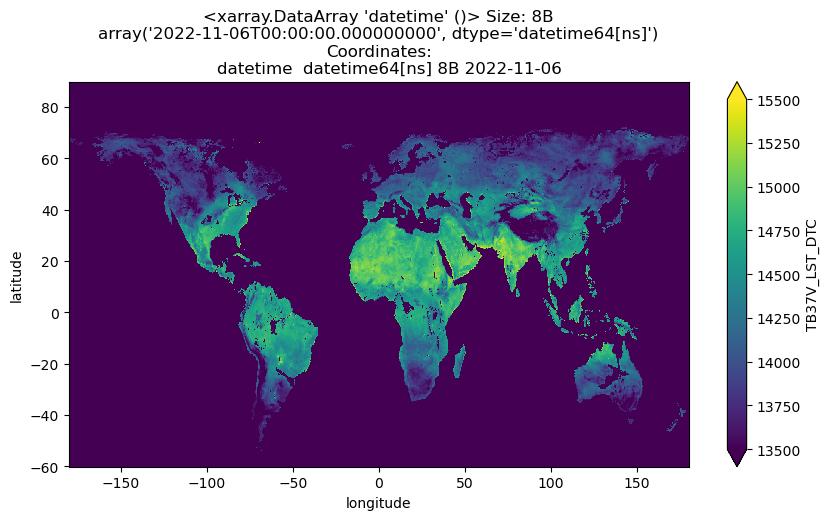

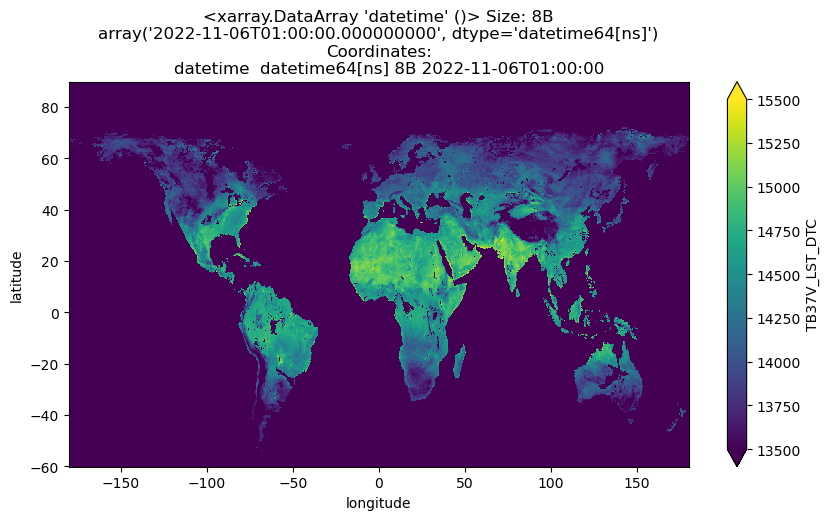

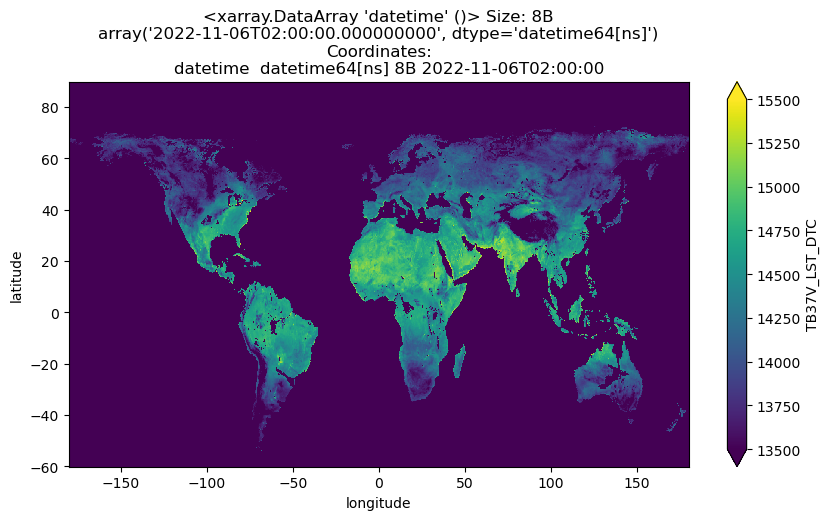

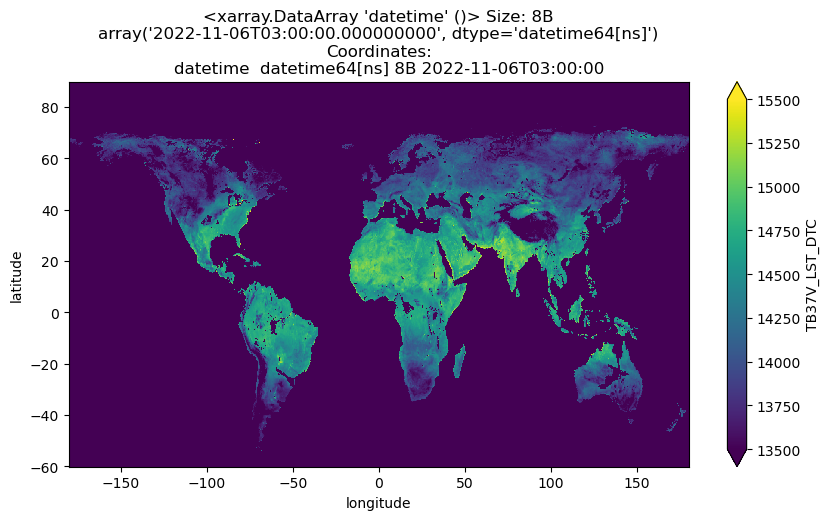

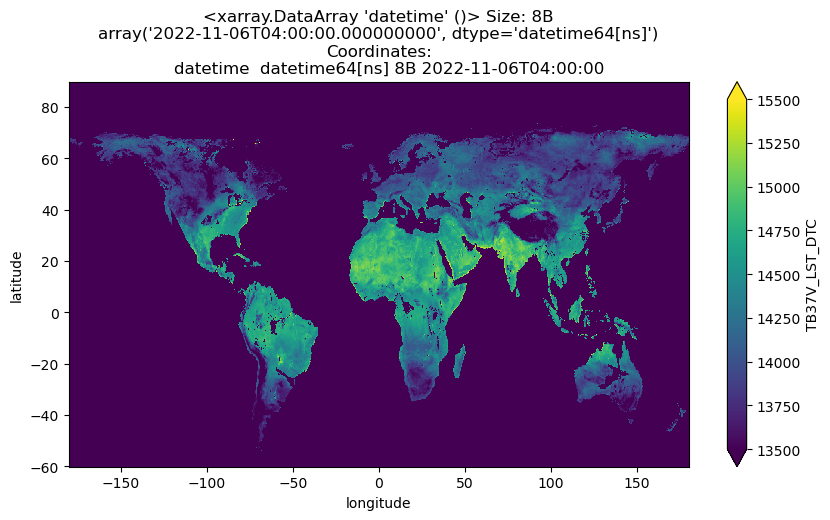

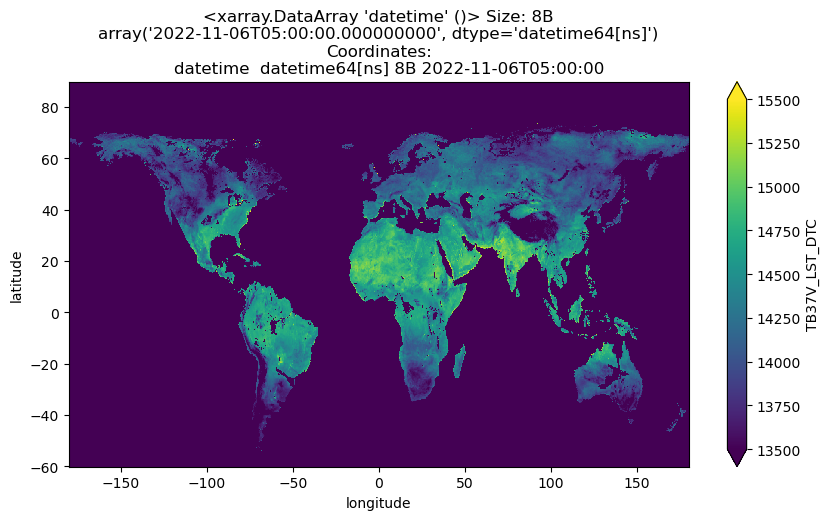

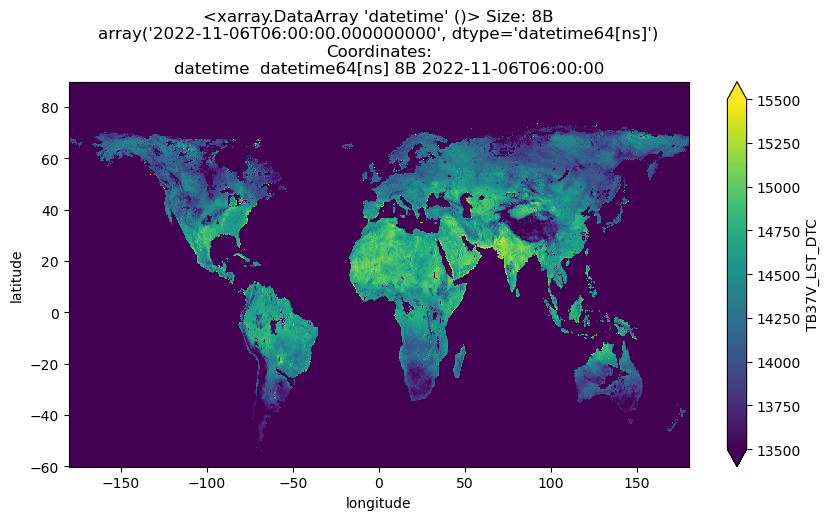

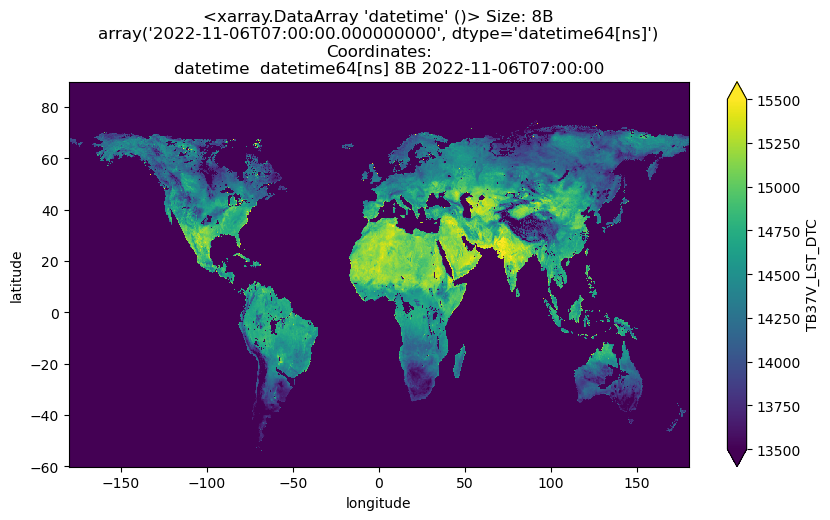

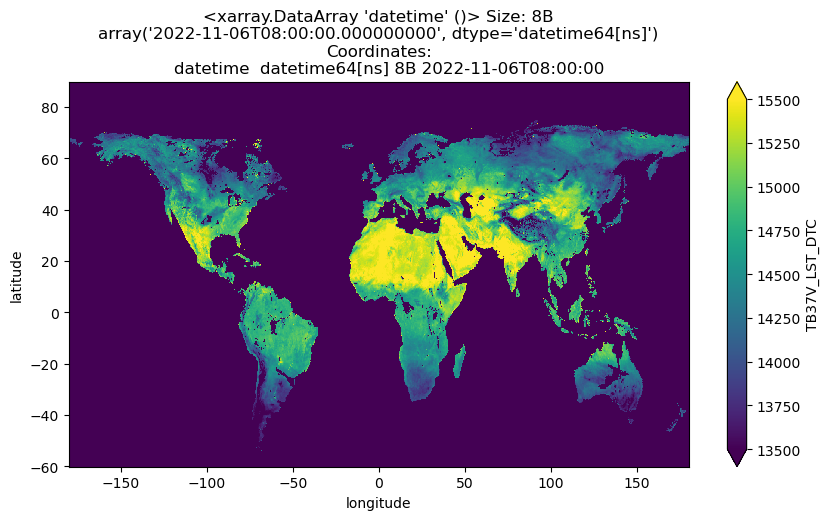

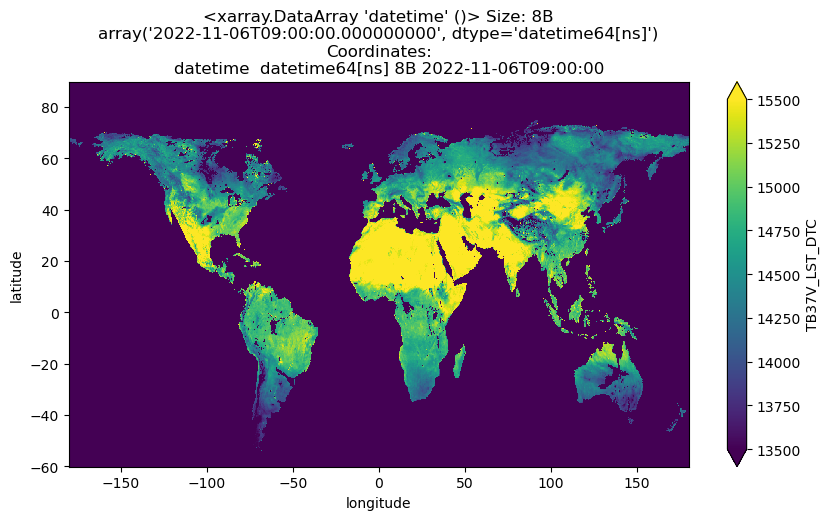

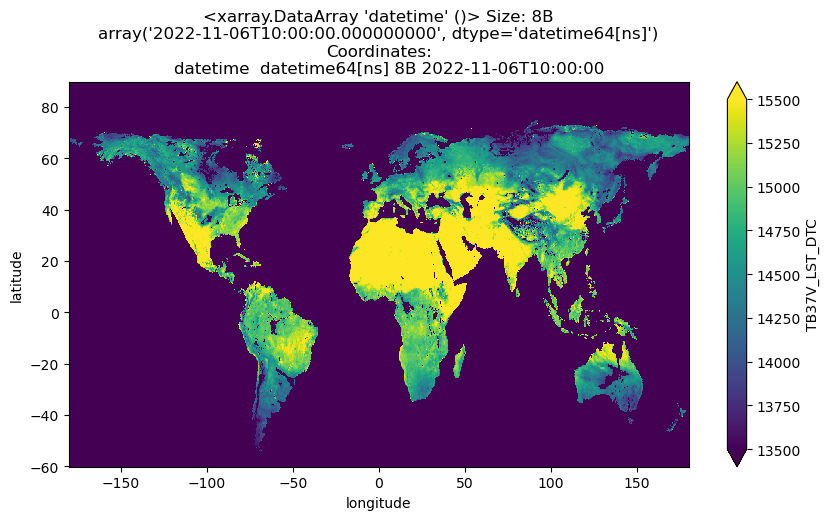

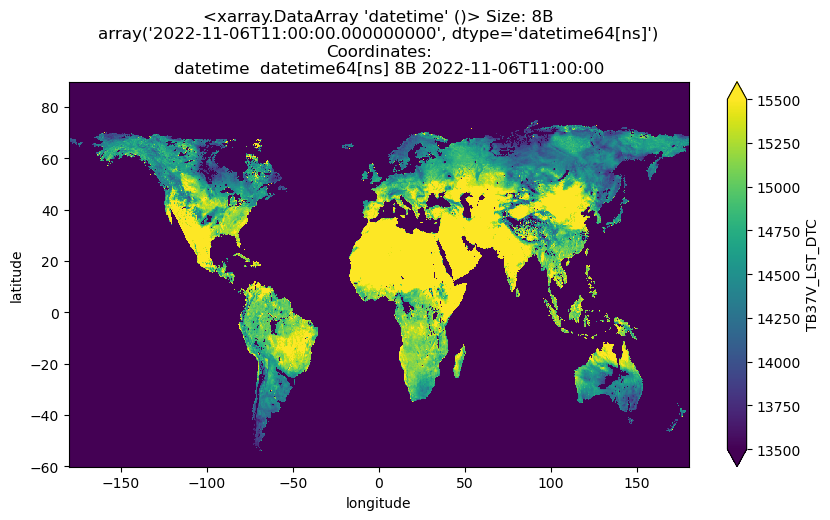

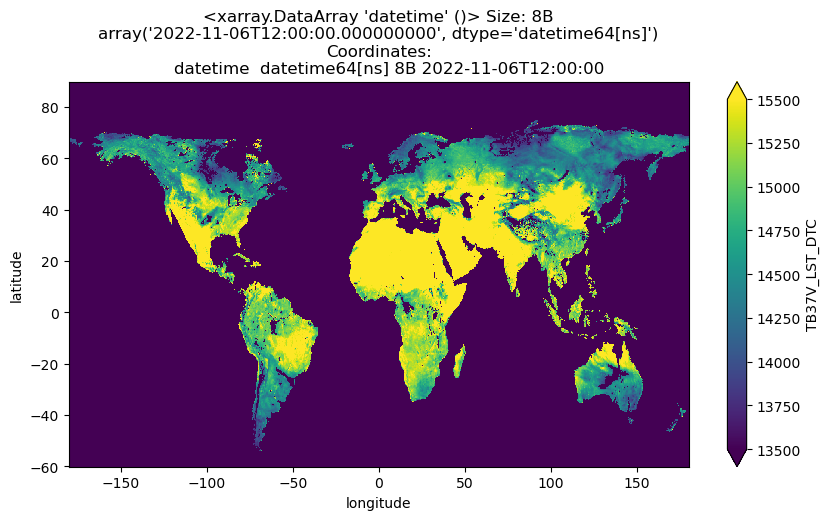

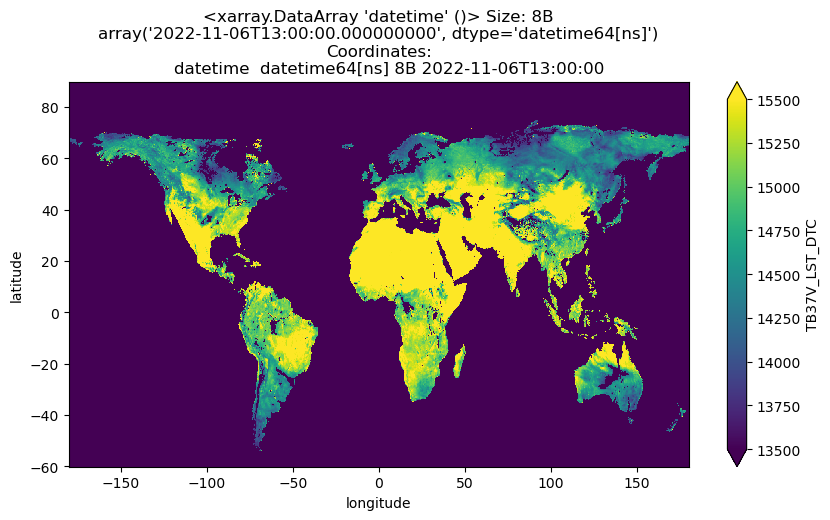

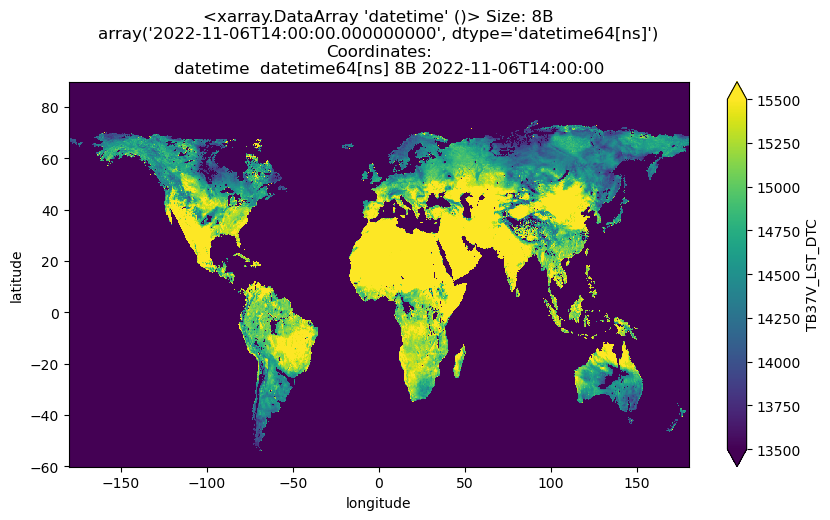

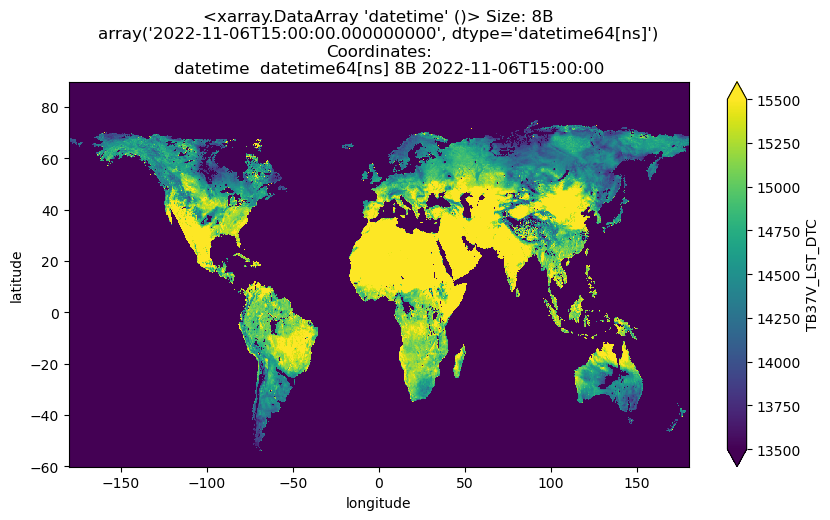

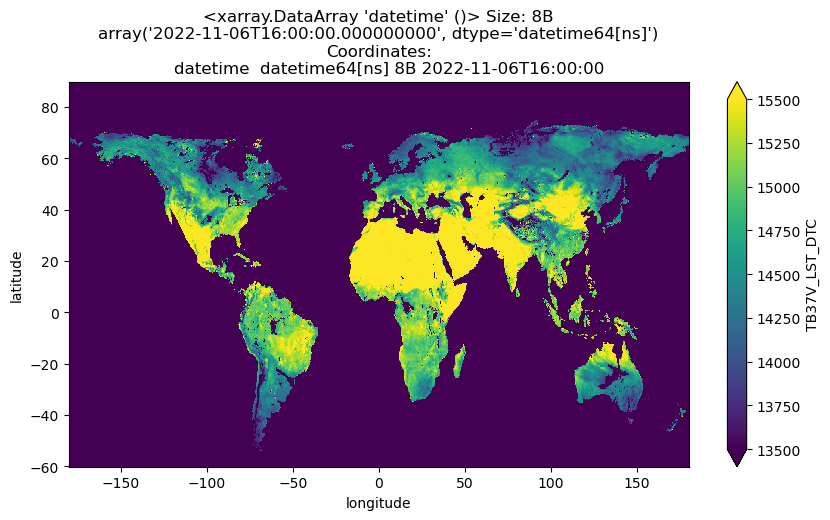

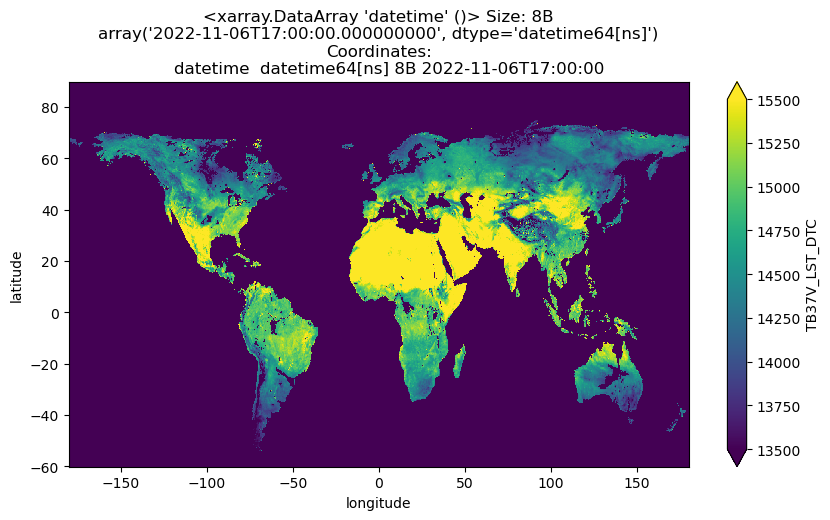

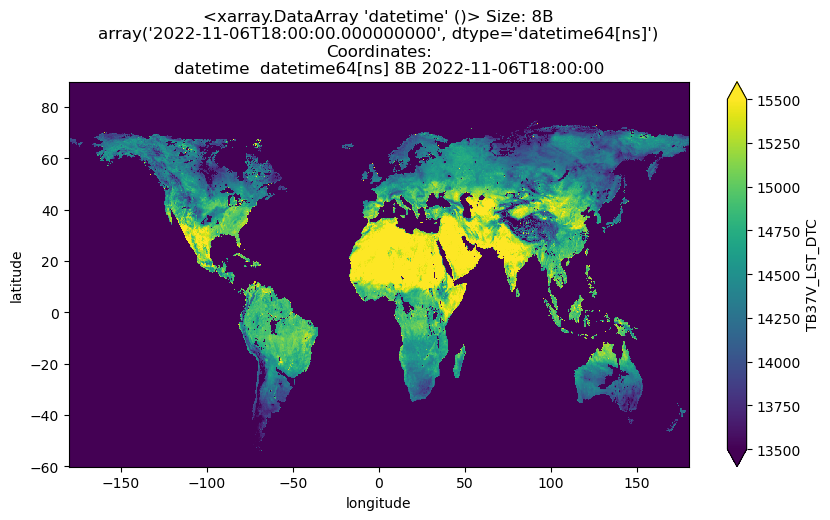

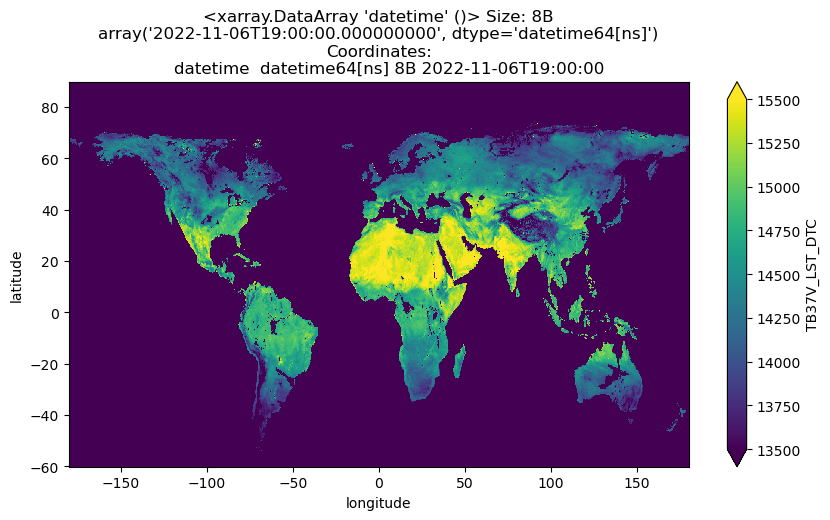

In [66]:
import matplotlib.pyplot as plt
for i in list(range(0, 80, 4)):
    #cb = plt.pcolormesh(dsMW['TB37V_LST_DTC'][i], vmin=13000, vmax=15000)
    dsMW['TB37V_LST_DTC'].isel(phony_dim_0=i).plot.pcolormesh("longitude", "latitude", vmin=13500, vmax=15500, figsize=(10,5))
    #plt.colorbar(cb)
    plt.title(dsMW['datetime'][i])
    #if i%24 == 0:
        #plt.savefig(f'../../photos/mw_{i}.jpg')
    plt.show()

In [166]:
np.max(latlon_pts_2km[:,:,0]), np.min(latlon_pts_2km[:,:,0]), np.max(latlon_pts_2km[:,:,1]), np.min(latlon_pts_2km[:,:,1])

(np.float64(-76.36824000890702),
 np.float64(-77.40617583434403),
 np.float64(39.48037320741648),
 np.float64(38.67140787501025))

In [167]:
def get_next_latlon_coord(n, above=True):
    if above:
        return np.ceil(n*4)/4
    else:
        return np.floor(n*4)/4

In [168]:
np.where(dsMW['latitude'] == 38.5)[0][0]

np.int64(205)

In [169]:
np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,1]), False))[0][0]

np.int64(205)

In [170]:
max_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.max(latlon_pts_2km[:,:,0]), True))[0][0]
min_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,0]), False))[0][0]
max_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.max(latlon_pts_2km[:,:,1]), True))[0][0]
min_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,1]), False))[0][0]

# Create microwave array for specific area
# Remember: latitude decreases with index
mw_clipped = dsMW['TB37V_LST_DTC'][15*4+3,min_lon_index:max_lon_index+1,max_lat_index:min_lat_index+1]

In [171]:
mw_clipped

<xarray.DataArray 'TB37V_LST_DTC' (phony_dim_1: 6, phony_dim_2: 5)> Size: 60B
[30 values with dtype=uint16]
Coordinates:
    datetime   datetime64[ns] 8B 2022-11-06T15:45:00
    longitude  (phony_dim_1) float64 48B -77.5 -77.25 -77.0 -76.75 -76.5 -76.25
    latitude   (phony_dim_2) float64 40B 39.5 39.25 39.0 38.75 38.5
Dimensions without coordinates: phony_dim_1, phony_dim_2
Attributes:
    Gain:     50.0
    NoData:   0.0
    Offset:   0.0

In [172]:
y, x = np.meshgrid(mw_clipped['latitude'], mw_clipped['longitude'])
mw_latlons = np.stack((x,y)).T.reshape(-1,2)
mw_latlons

array([[-77.5 ,  39.5 ],
       [-77.25,  39.5 ],
       [-77.  ,  39.5 ],
       [-76.75,  39.5 ],
       [-76.5 ,  39.5 ],
       [-76.25,  39.5 ],
       [-77.5 ,  39.25],
       [-77.25,  39.25],
       [-77.  ,  39.25],
       [-76.75,  39.25],
       [-76.5 ,  39.25],
       [-76.25,  39.25],
       [-77.5 ,  39.  ],
       [-77.25,  39.  ],
       [-77.  ,  39.  ],
       [-76.75,  39.  ],
       [-76.5 ,  39.  ],
       [-76.25,  39.  ],
       [-77.5 ,  38.75],
       [-77.25,  38.75],
       [-77.  ,  38.75],
       [-76.75,  38.75],
       [-76.5 ,  38.75],
       [-76.25,  38.75],
       [-77.5 ,  38.5 ],
       [-77.25,  38.5 ],
       [-77.  ,  38.5 ],
       [-76.75,  38.5 ],
       [-76.5 ,  38.5 ],
       [-76.25,  38.5 ]])

In [173]:
latlon_pts_2km

array([[[-77.40617583,  39.46370501],
        [-77.3829467 ,  39.46418358],
        [-77.35971702,  39.46465751],
        ...,
        [-76.4301392 ,  39.47981056],
        [-76.40689153,  39.48009421],
        [-76.38364354,  39.48037321]],

       [[-77.40555572,  39.44569963],
        [-77.38233256,  39.44617789],
        [-77.35910885,  39.44665152],
        ...,
        [-76.42977035,  39.46179493],
        [-76.40652867,  39.4620784 ],
        [-76.38328667,  39.46235722]],

       [[-77.40493616,  39.42769418],
        [-77.38171897,  39.42817214],
        [-77.35850123,  39.42864547],
        ...,
        [-76.42940183,  39.44377925],
        [-76.40616614,  39.44406253],
        [-76.38293012,  39.44434118]],

       ...,

       [[-77.38060352,  38.70742405],
        [-77.3576207 ,  38.70788996],
        [-77.33463735,  38.70835136],
        ...,
        [-76.41492861,  38.72310362],
        [-76.391928  ,  38.72337977],
        [-76.36892708,  38.72365139]],

       [[-77.38

In [174]:
mw_vals = mw_clipped.T.values.reshape(-1)
mw_vals

array([15132, 15170, 15161, 15237, 15279, 15074, 15282, 15196, 15264,
       15416, 15233, 15257, 15240, 15290, 15400, 15443,     0, 15109,
       15345, 15389, 15484, 15353,     0, 15137, 15221, 15172, 15400,
       15258,     0, 15116], dtype=uint16)

In [175]:
mw_vals/50

array([302.64, 303.4 , 303.22, 304.74, 305.58, 301.48, 305.64, 303.92,
       305.28, 308.32, 304.66, 305.14, 304.8 , 305.8 , 308.  , 308.86,
         0.  , 302.18, 306.9 , 307.78, 309.68, 307.06,   0.  , 302.74,
       304.42, 303.44, 308.  , 305.16,   0.  , 302.32])

In [176]:
mw_linear = interpolate.griddata(mw_latlons, mw_vals/50, latlon_pts_2km, method='linear')
mw_linear = np.where(mw_linear < 200, np.nanmean(mw_linear), mw_linear)
mw_linear

array([[303.00071904, 303.07034019, 303.13997265, ..., 304.72985628,
        304.34444195, 303.95909029],
       [303.04005538, 303.109659  , 303.17927393, ..., 304.98755589,
        304.60224245, 304.21699165],
       [303.07939016, 303.14897628, 303.21857369, ..., 305.24526179,
        304.86004916, 304.47489913],
       ...,
       [306.8979222 , 306.98344357, 307.06892204, ..., 266.58947678,
        266.58947678, 266.58947678],
       [306.72138451, 306.80688268, 306.89233796, ..., 266.58947678,
        266.58947678, 266.58947678],
       [306.54484431, 306.63031929, 306.71575142, ..., 266.58947678,
        266.58947678, 266.58947678]], shape=(45, 45))

In [177]:
mw_nn = interpolate.griddata(mw_latlons, mw_vals/50, latlon_pts_2km, method='nearest')
mw_nn = np.where(mw_nn == 0, np.nanmean(mw_nn), mw_nn)
mw_nn

array([[302.64      , 302.64      , 303.4       , ..., 305.58      ,
        305.58      , 305.58      ],
       [302.64      , 302.64      , 303.4       , ..., 305.58      ,
        305.58      , 305.58      ],
       [302.64      , 302.64      , 303.4       , ..., 305.58      ,
        305.58      , 305.58      ],
       ...,
       [306.9       , 307.78      , 307.78      , ..., 266.29828148,
        266.29828148, 302.74      ],
       [306.9       , 307.78      , 307.78      , ..., 266.29828148,
        266.29828148, 302.74      ],
       [306.9       , 307.78      , 307.78      , ..., 266.29828148,
        266.29828148, 302.74      ]], shape=(45, 45))

In [178]:
LST_nn = interpolate.griddata(utm_coords, mw_nn.reshape(-1,), utm_coords_LS, method='nearest').reshape((3000,3000))
LST_linear = interpolate.griddata(utm_coords, mw_linear.reshape(-1,), utm_coords_LS, method='nearest').reshape((3000,3000))

In [179]:
np.nanmean(dsLS[6].values-LST_nn), np.nanmean(dsLS[6].values-LST_linear)

(np.float64(-6.2054955466774775), np.float64(0.1662714987970722))

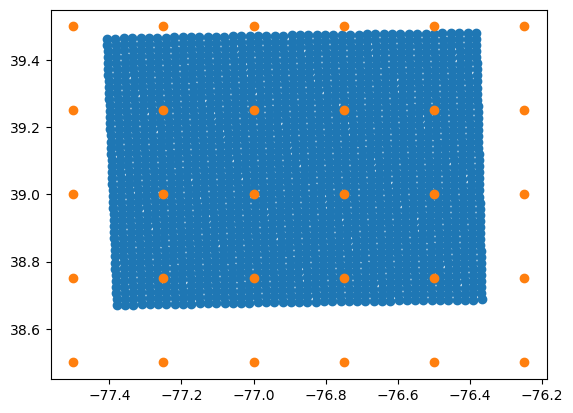

In [48]:
plt.scatter(latlon_pts_2km[:,:,0], latlon_pts_2km[:,:,1])
plt.scatter(mw_latlons[:,0], mw_latlons[:,1])

In [104]:
geotiff_dsG['microwave_LST'] = (('y','x'), mw_interpolated)

In [105]:
geotiff_dsG = geotiff_dsG.assign_attrs(long_name='(\'CMI_C13\', \'CMI_C14\', \'CMI_C15\', \'CMI_C16\', \'mw_LST\')')

In [106]:
geotiff_dsG = geotiff_dsG.reindex(y=geotiff_dsG.y[::-1])

In [107]:
geotiff_dsG

<xarray.Dataset> Size: 82kB
Dimensions:        (x: 45, y: 45)
Coordinates:
  * x              (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y              (y) float64 360B 4.283e+06 4.285e+06 ... 4.369e+06 4.371e+06
    spatial_ref    int64 8B 0
    datetime       object 8B 2022-01-01T00:00:20.500000+00:00
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB 283.8 283.6 283.6 ... 274.9 275.9 276.9
    microwave_LST  (y, x) float64 16kB 1.418e+04 1.418e+04 ... 1.417e+04
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               ('CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'mw...

In [94]:
geotiff_dsG.to_netcdf('../../heat_data/GOES_DMV_2km/processed_GOES_2km_0')

## Export and re-open

In [226]:
# Export the data
#geotiff_dsLS.rio.to_raster("../../Landsat_Sentinel_DMV_processed/Landsat_sample.tif")
#geotiff_dsG.rio.to_raster("../../Landsat_Sentinel_DMV_processed/GOES_sample.tif")
geotiff_dsG.to_netcdf("../../Landsat_Sentinel_DMV_processed/GOES_sample.nc")

In [95]:
ds = xr.open_dataset('../../heat_data/GOES_DMV_2km/processed_GOES_2km_0')
ds

<xarray.Dataset> Size: 70kB
Dimensions:        (y: 45, x: 45)
Coordinates:
  * x              (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y              (y) float64 360B 4.371e+06 4.369e+06 ... 4.285e+06 4.283e+06
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB ...
    spatial_ref    int64 8B ...
    microwave_LST  (y, x) uint16 4kB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'mw_LST')
    Datetime:       2023-06-01 00:46:17.400000+00:00

In [63]:
rxr.open_rasterio("../../GOES_DMV_processed/processed_GOES_tif_0.tif")

<xarray.DataArray (band: 4, y: 3000, x: 3000)>
[36000000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.92e+05 2.92e+05 2.921e+05 ... 3.82e+05 3.82e+05
  * y            (y) float64 4.372e+06 4.372e+06 ... 4.282e+06 4.282e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    Datetime:       2023-05-31 23:46:17.400000
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('GOES_C13_LWIR', 'GOES_C14_LWIR', 'GOES_C15_LWIR', 'GOES...

## Processing Functions

In [11]:
"""
Processing of individual .tif files.

Performs a variety of tasks on the data to make it more easy to read and understand.

Attributes:
    tif (str): Path where tif file is located.
    time (str): Date and time of when the data was collected format YYYY-MM-DDThh:mm:ssZ.
    coord_bounds (tuple or list, optional): Coordinate bounds if you wish to filter the data by location. Order should be
                                    (longitude minimum, longitude maximum, latitude minimum, latitude maximum).
"""
def process_Landsat_Sentinel_tif(tif, time, coord_bounds=None):
    #########################################################################################################
    # Open file and rename variables
    dsLS = rxr.open_rasterio(tif)[:,:3000,:3000] 
    dsLS = dsLS.reindex(y=dsLS.y[::-1]) # Invert y-axis so that values are increasing instead of decreasing with index
    geotiff_ds = dsLS.to_dataset('band')

    geotiff_ds = geotiff_ds.rename({1:'Landsat_blue_reflectance', 2:'Landsat_green_reflectance', 3:'Landsat_red_reflectance',
                                    4:'Landsat_NIR_reflectance', 5:'Landsat_SWIR1_reflectance', 6:'Landsat_SWIR2_reflectance',
                                    7:'Landsat_LST', 8:'Landsat_cloud_mask', 9:'Sentinel1_VV', 10:'Sentinel1_VH', 11:'Sentinel1_HH',
                                    12:'Sentinel1_HV', 13:'Sentinel1_angle'})

    #########################################################################################################
    # Convert cloud mask integers to binary strings
    binary_vectorized = np.vectorize(to_binary_string)
    mask = binary_vectorized(geotiff_ds.Landsat_cloud_mask.values)
    geotiff_ds['Landsat_cloud_mask'] = (('y', 'x'), mask)

    #cloud_conf_substring = lambda t: t[-10:-8]
    #vfunc = np.vectorize(cloud_conf_substring)
    #cloud_conf = vfunc(mask)
    #cloud_conf_int = (cloud_conf == '11').astype(int)*3
    #cloud_conf_int += (cloud_conf == '10')*2
    #cloud_conf_int += (cloud_conf == '01')
    #cloud_conf_str = cloud_conf_int.astype(str)

    #cloud_shadow_substring = lambda t: t[-12:-10]
    #vfunc = np.vectorize(cloud_shadow_substring)
    #cloud_shadow = vfunc(mask)
    #cloud_shadow_int = (cloud_shadow == '11').astype(int)*3
    #cloud_shadow_int += (cloud_shadow == '10')*2
    #cloud_shadow_int += (cloud_shadow == '01')
    #cloud_shadow_str = cloud_shadow_int.astype(str)

    #snow_ice_substring = lambda t: t[-14:-12]
    #vfunc = np.vectorize(snow_ice_substring)
    #snow_ice = vfunc(mask)
    #snow_ice_int = (snow_ice == '11').astype(int)*3
    #snow_ice_int += (snow_ice == '10')*2
    #snow_ice_int += (snow_ice == '01')
    #snow_ice_str = snow_ice_int.astype(str)

    #cirrus_conf_substring = lambda t: t[-16:-14]
    #vfunc = np.vectorize(cirrus_conf_substring)
    #cirrus_conf = vfunc(mask)
    #cirrus_conf_int = (cirrus_conf == '11').astype(int)*3
    #cirrus_conf_int += (cirrus_conf == '10')*2
    #cirrus_conf_int += (cirrus_conf == '01')
    #cirrus_conf_str = cirrus_conf_int.astype(str)

    #dilated_cloud_substring = lambda t: t[-2]
    #vfunc = np.vectorize(dilated_cloud_substring)
    #dilated_cloud = vfunc(mask)

    #clear_substring = lambda t: t[-7]
    #vfunc = np.vectorize(clear_substring)
    #clear = vfunc(mask)

    #geotiff_ds['Landsat_Cloud_Confidence'] = (('y', 'x'), cloud_conf_str)
    #geotiff_ds['Landsat_Cloud_Shadow_Confidence'] = (('y', 'x'), cloud_shadow_str)
    #geotiff_ds['Landsat_Snow_Ice_Confidence'] = (('y', 'x'), snow_ice_str)
    #geotiff_ds['Landsat_Cirrus_Confidence'] = (('y', 'x'), cirrus_conf_str)
    #geotiff_ds['Landsat_Dilated_Cloud'] = (('y', 'x'), dilated_cloud)
    #geotiff_ds['Landsat_Clear_Pixel'] = (('y', 'x'), clear)

    #geotiff_ds = geotiff_ds.drop_vars('Landsat_Cloud_Mask')

    #########################################################################################################
    # Assign descriptive attributes for the cloud mask and a new coordinate for the file datetime
    geotiff_ds['Landsat_cloud_mask'].attrs['bitmask_key'] = \
    "Bit 0: Fill\n\
    Bit 1: Dilated Cloud\n\
    Bit 2: Cirrus (high confidence)\n\
    Bit 3: Cloud\n\
    Bit 4: Cloud Shadow\n\
    Bit 5: Snow\n\
    Bit 6: Clear\n\t0: Cloud or Dilated Cloud bits are set\n\t1: Cloud and Dilated Cloud bits are not set\n\
    Bit 7: Water\n\
    Bits 8-9: Cloud Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 10-11: Cloud Shadow Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 12-13: Snow/Ice Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 14-15: Cirrus Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High"

    geotiff_ds = geotiff_ds.assign_coords({'datetime':time})
    del geotiff_ds.attrs['long_name']
    
    #########################################################################################################
    # Optional filtering by lat/lon
    if coord_bounds:
        geotiff_ds = geotiff_ds.sel(longitude=slice(coord_bounds[0], coord_bounds[1])).sel(latitude=slice(coord_bounds[3], coord_bounds[2]))

    #########################################################################################################
    return geotiff_ds

In [26]:
dt = datetime.datetime.fromtimestamp(times_Landsat[0]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = process_Landsat_Sentinel_tif(Landsat_tif_list[0], dt)
ds

ERROR! Session/line number was not unique in database. History logging moved to new session 185


<xarray.Dataset> Size: 1GB
Dimensions:                    (y: 3000, x: 3000)
Coordinates:
  * x                          (x) float64 24kB 3.26e+05 3.261e+05 ... 4.16e+05
  * y                          (y) float64 24kB 6.115e+06 ... 6.205e+06
    spatial_ref                int64 8B 0
    datetime                   <U20 80B '2022-01-07T13:44:52Z'
Data variables: (12/13)
    Landsat_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance  (y, x) float64 72MB ...
    Landsat_red_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_reflectance  (y, x) float64 72MB ...
    ...                         ...
    Landsat_cloud_mask         (y, x) <U16 576MB '101010101000000' ... '10101...
    Sentinel1_VV               (y, x) float64 72MB ...
    Sentinel1_VH               (y, x) float64 72MB ...
    Sentinel1_HH               (y, x) float64 72MB ...
    Sentinel1_HV               (y, x) float64 72MB ...
    Sentinel1_angle            (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [28]:
# Runs processing function on all the geotif files
#coord_bounds = [-76.761259, -76.404021, 39.202514, 39.422284]
processed_dir = f'/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/{city}/processed_Landsat'

for i in range(len(Landsat_tif_list)):
    fname = Landsat_tif_list[i].split('/')[-1].split('.')[0]
    dt = datetime.datetime.fromtimestamp(times_Landsat[i]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
    ds = process_Landsat_Sentinel_tif(Landsat_tif_list[i], dt)
    ds.to_netcdf(f'{processed_dir}/{fname}.nc')

In [17]:
ds = xr.open_dataset('/home/jonstar/scratch/processed_Landsat_data/Landsat_Sentinel_image_Bogota_202204131512.nc')

In [28]:
ds

<xarray.Dataset> Size: 936MB
Dimensions:                    (y: 3000, x: 3000)
Coordinates:
  * x                          (x) float64 24kB 5.464e+05 ... 6.364e+05
  * y                          (y) float64 24kB 4.718e+05 ... 5.617e+05
    datetime                   object 8B '2022-04-13T15:12:35Z'
Data variables: (12/14)
    Landsat_cloud_mask         (y, x) object 72MB '1101011100001100' ... '110...
    Landsat_blue_reflectance   (y, x) float64 72MB 0.1729 0.1719 ... 0.934
    Landsat_green_reflectance  (y, x) float64 72MB ...
    Landsat_red_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance  (y, x) float64 72MB ...
    ...                         ...
    Sentinel1_VV               (y, x) float64 72MB ...
    Sentinel1_VH               (y, x) float64 72MB ...
    Sentinel1_HH               (y, x) float64 72MB ...
    Sentinel1_HV               (y, x) float64 72MB ...
    Sentinel1_angle            (y, x) float64 72MB ...
    spatial_ref                int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [62]:
"""
Processing of individual .tif files.

Performs a variety of tasks on the data to make it more easy to read and understand.

Attributes:
    tif (str): Path where tif file is located.
    time (str): Date and time of when the data was collected format YYYY-MM-DDThh:mm:ssZ.
    latlon_pts (float array): (3000,3000,2) Array of (longitude, latitude) points at each point on the utm grid.
    local_timezone (pytz timezone): Local timezone of the area you are creating data for
    coord_bounds (tuple or list, optional): Coordinate bounds if you wish to filter the data by location. Order should be
                                    (longitude minimum, longitude maximum, latitude minimum, latitude maximum).
"""
def process_GOES_tif(tif, time, latlon_pts, local_timezone, coord_bounds=None):
    #########################################################################################################
    # Open file and rename variables
    dsG = rxr.open_rasterio(tif)
    geotiff_ds = dsG.to_dataset('band')

    geotiff_ds = geotiff_ds.rename({1:'GOES_C13_LWIR', 2:'GOES_C14_LWIR',
                                      3:'GOES_C15_LWIR', 4:'GOES_C16_LWIR'})

    geotiff_ds = geotiff_ds.assign_coords({'datetime':time})

    #########################################################################################################
    # Process microwave data
    local_dt = toTimezone(time, local_timezone)
    date_str = str(local_dt)[0:4] + str(local_dt)[5:7] + str(local_dt)[8:10]
    time_index = local_dt.hour*4 + round(local_dt.minute/15+local_dt.second/60) # Used in selection of datetime index from mw file (every 15 minutes)
    
    dsMW = xr.open_dataset(f'/Users/jonstar/Documents/heat_data/mw_data/MW_LST_DTC_{date_str}_x1y.h5')
    dsMW = dsMW.assign_coords(
                datetime=("phony_dim_0", pd.date_range(start=date_str, periods=96, freq="15min")),
                longitude=("phony_dim_1", np.arange(-180,180,0.25)),
                latitude=("phony_dim_2", np.arange(-60,90,0.25)[::-1]))
    #dsMW = dsMW.rename({'phony_dim_0':'datetime', 'phony_dim_1':'longitude', 'phony_dim_2':'latitude'})

    def get_next_latlon_coord(n, above=True):
        if above:
            return np.ceil(n*4)/4
        else:
            return np.floor(n*4)/4

    max_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.max(latlon_pts[:,:,0]), True))[0][0]
    min_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.min(latlon_pts[:,:,0]), False))[0][0]
    max_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.max(latlon_pts[:,:,1]), True))[0][0]
    min_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts[:,:,1]), False))[0][0]

    # Create microwave array for specific area
    # Remember: latitude decreases with index
    mw_clipped = dsMW['TB37V_LST_DTC'][time_index,min_lon_index:max_lon_index+1,max_lat_index:min_lat_index+1]

    y, x = np.meshgrid(mw_clipped['latitude'], mw_clipped['longitude'])
    mw_latlons = np.stack((x,y)).T.reshape(-1,2)
    mw_vals = mw_clipped.T.values.reshape(-1)
    mw_interpolated = interpolate.griddata(mw_latlons, mw_vals, latlon_pts_2km)
    geotiff_dsG['microwave_LST'] = (('y','x'), mw_interpolated)

    # Delete long_name attribute, which prevents netCDF from saving
    del geotiff_ds.attrs['long_name']

    # Flip coordinates so latitude increases with index
    geotiff_ds = geotiff_ds.reindex(y=geotiff_ds.y[::-1])

    #########################################################################################################
    # Optional filtering by lat/lon
    if coord_bounds:
        geotiff_ds = geotiff_ds.sel(longitude=slice(coord_bounds[0], coord_bounds[1])).sel(latitude=slice(coord_bounds[3], coord_bounds[2]))

    #########################################################################################################
    return geotiff_ds

In [41]:
# Runs processing function on all the geotif files
#coord_bounds = [-76.761259, -76.404021, 39.202514, 39.422284]

#for i in list(range(len(GOES_tif_list))):
for i in list(range(1)):
    #i += 170
    dt = times_GOES.value[i]
    process_GOES_tif(GOES_tif_list[i], dt,
                     f'../../heat_data/GOES_DMV_processed/processed_GOES_tif_{toTimezone(dt,pytz.utc).strftime('%Y%m%d%H%M')}',
                     latlon_pts_2km, az)

In [157]:
ds = xr.open_dataset('../../heat_data/GOES_DMV_processed/processed_GOES_tif_0.nc')

In [158]:
ds

<xarray.Dataset> Size: 70kB
Dimensions:        (x: 45, y: 45)
Coordinates:
  * x              (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y              (y) float64 360B 4.283e+06 4.285e+06 ... 4.369e+06 4.371e+06
    datetime       <U32 128B ...
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB ...
    spatial_ref    int64 8B ...
    microwave_LST  (y, x) uint16 4kB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'mw_LST')

In [ ]:
######################################################
# End of tif processing part
# Below is gridding of Baltimore

In [31]:
grid_lats = [39.2576, 39.3147, 39.3718]
grid_lons = [-76.5299, -76.6204, -76.7108]

In [37]:
grid1 = geotiff_ds.sel(longitude=slice(grid_lons[2], grid_lons[1])).sel(latitude=slice(grid_lats[2], grid_lats[1]))
grid2 = geotiff_ds.sel(longitude=slice(grid_lons[1], grid_lons[0])).sel(latitude=slice(grid_lats[2], grid_lats[1]))
grid3 = geotiff_ds.sel(longitude=slice(grid_lons[2], grid_lons[1])).sel(latitude=slice(grid_lats[1], grid_lats[0]))
grid4 = geotiff_ds.sel(longitude=slice(grid_lons[1], grid_lons[0])).sel(latitude=slice(grid_lats[1], grid_lats[0]))

In [38]:
grid4

<xarray.Dataset>
Dimensions:                             (latitude: 212, longitude: 336)
Coordinates:
  * longitude                           (longitude) float64 -76.62 ... -76.53
  * latitude                            (latitude) float64 39.31 39.31 ... 39.26
    spatial_ref                         int64 0
Data variables: (12/14)
    Landsat_Blue_Vis_Sfc_Reflectance    (latitude, longitude) float64 ...
    Landsat_Red_Vis_Sfc_Reflectance     (latitude, longitude) float64 ...
    Landsat_NIR_Sfc_Reflectance         (latitude, longitude) float64 ...
    Landsat_SWIR1_Sfc_Reflectance       (latitude, longitude) float64 ...
    Landsat_SWIR2_Sfc_Reflectance       (latitude, longitude) float64 ...
    Landsat_LST                         (latitude, longitude) float64 ...
    ...                                  ...
    GOES_Red_Vis_Reflectance            (latitude, longitude) float64 ...
    GOES_NIR_Veggie_Reflectance         (latitude, longitude) float64 ...
    GOES_NIR_SnowIce_Reflectance        (latitude, longitude) float64 ...
    GOES_NIR_CloudParticle_Reflectance  (latitude, longitude) float64 ...
    GOES_LWIR_Brightness_Temp           (latitude, longitude) float64 ...
    GOES_Dirty_LWIR_Brightness_temp     (latitude, longitude) float64 ...
Attributes:
    AREA_OR_POINT:    Area
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        ('SR_B2', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',...
    Cloud_Mask_Bits:  Bit 0: Fill\nBit 1: Dilated Cloud\nBit 2: Cirrus (high ...
    Datetime:         2023-01-11 10:46:33.089500